# Evaluate water mass properties on the Amundsen Shelf with vertical profiles

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux
from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.grid import region_mask

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test6/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

# Vertical profiles

In [3]:
nemo_file = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc').squeeze()
mask, _, region_name = region_mask('pine_island_bay', nemo_file, option='shelf', return_name=True)

In [4]:
def obs_region(fileT, fileS, mask=mask, nemo_file=nemo_file):

    #  set region limits based on min and max value in mask (not the exact solution but ok for now):
    mask_lon_min = (mask*nemo_file.nav_lon).min().values
    mask_lon_max = xr.where(mask*nemo_file.nav_lon !=0, mask*nemo_file.nav_lon, np.nan).max().values
    mask_lat_min = (mask*nemo_file.nav_lat).min().values
    mask_lat_max = xr.where(mask*nemo_file.nav_lat !=0, mask*nemo_file.nav_lat, np.nan).max().values
    
    #  load observations
    if type(fileT) == list:
        i=0
        for fT, fS in zip(fileT, fileS):
            if i==0:
                obs = read_dutrieux(eos='teos10', fileT=fT, fileS=fS)
            else:
                obs_new = read_dutrieux(eos='teos10', fileT=fT, fileS=fS)
                obs = xr.concat([obs, obs_new], 'year')
            i+=1
    else:
        obs = read_dutrieux(eos='teos10', fileT=fileT, fileS=fileS)
    array_mask   = (obs.lon >= mask_lon_min)*(obs.lon <= mask_lon_max)*(obs.lat >= mask_lat_min)*(obs.lat <= mask_lat_max)
    # mask observations:
    obs_T_masked = xr.where((array_mask)*(obs.ConsTemp!=0), obs.ConsTemp, np.nan)
    obs_S_masked = xr.where((array_mask)*(obs.AbsSal!=0), obs.AbsSal, np.nan)
    
    return obs_T_masked, obs_S_masked

In [5]:
def sim_region(gridT_files, mask=mask):
    
    # load all the gridT files in the run folder
    nemo_ds     = xr.open_mfdataset(gridT_files) 
    nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                              'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                              'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                              'nvertex_grid_T':'nvertex'})
    dates_month  = nemo_ds.time_counter.dt.month
    nemo_ds      = nemo_ds.isel(time_counter=((dates_month==1) | (dates_month==2))) # select only January and February
    
    # Average full time series: ## average only over January and February of each year
    nemo_T = nemo_ds.thetao.isel(x=slice(450, 850), y=slice(140,300))
    nemo_S = nemo_ds.so.isel(x=slice(450, 850), y=slice(140,300))
    
    # region masked: fill regions outside of the mask with NaN and replace zeros with NaN for averaging
    nemo_T_masked = xr.where((mask!=0)*(nemo_T!=0), nemo_T, np.nan)
    nemo_S_masked = xr.where((mask!=0)*(nemo_S!=0), nemo_S, np.nan)
    
    return nemo_T_masked, nemo_S_masked

In [6]:
yearly_Tobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_PT.nc')
yearly_Sobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_S.nc')

mask, _, region_name = region_mask('amundsen_sea', nemo_file, option='all', return_name=True)
obs_T, obs_S = obs_region(yearly_Tobs[0], yearly_Sobs[0], mask=mask, nemo_file=nemo_file)

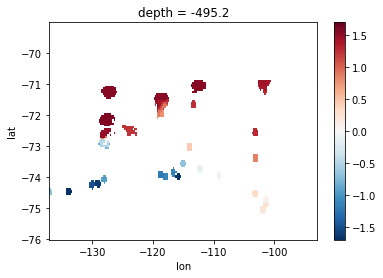

In [22]:
obs_T.isel(depth=500).plot(x='lon', y='lat')

In [7]:
region = 'pine_island_bay'
option = 'shelf'

def plot_regional_profile(region, nemo_file, option, fig_name=None, dpi=None):

    mask, _, region_name = region_mask(region, nemo_file, option=option, return_name=True)
    mask_subset = mask.isel(x=slice(450, 850), y=slice(140,300))

    yearly_Tobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_PT.nc')
    yearly_Sobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_S.nc')
    yearly_TSsim = glob.glob(f'{run_folder}files/*grid_T*')[21:]
    
    #----------- Figure ----------
    fig, ax = figure_setup(region_name)
    
    for axis in ax.ravel():
        axis.xaxis.grid(True, which='major', linestyle='dotted')
        axis.yaxis.grid(True, which='major', linestyle='dotted')
    
    # yearly model simulations:
    for file in yearly_TSsim:
        sim_T, sim_S = sim_region(file, mask=mask_subset)
        ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=0.5)
        ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_S.deptht, '-k', linewidth=0.5)
    # mean over all the years:
    sim_T, sim_S = sim_region(yearly_TSsim, mask=mask_subset)
    ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=2, label='Model')
    ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=2)
    # standard deviation
    ax[1].plot(sim_T.mean(dim=['x','y']).std(dim='time_counter'), sim_T.deptht, '-k')
    ax[3].plot(sim_S.mean(dim=['x','y']).std(dim='time_counter'), sim_S.deptht, '-k')
    
    #  same but for observations;
    for obsT, obsS in zip(yearly_Tobs, yearly_Sobs):
        obs_T, obs_S = obs_region(obsT, obsS, mask=mask, nemo_file=nemo_file)
        ax[0].plot(obs_T.mean(dim=['lon','lat']), abs(obs_T.depth), '--c', linewidth=0.5)
        ax[2].plot(obs_S.mean(dim=['lon','lat']), abs(obs_S.depth), '--c', linewidth=0.5)
    # mean over all the years 
    obs_T, obs_S = obs_region(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean_PT.nc', 
                              f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean_S.nc', 
                              mask=mask, nemo_file=nemo_file)
    ax[0].plot(obs_T.mean(dim=['lon','lat']), abs(obs_T.depth), '--c', linewidth=2, label='Observations')
    ax[2].plot(obs_S.mean(dim=['lon','lat']), abs(obs_S.depth), '--c', linewidth=2)
    # standard deviation
    obs_T_yearly, obs_S_yearly = obs_region(yearly_Tobs, yearly_Sobs, mask=mask, nemo_file=nemo_file)
    ax[1].plot(obs_T_yearly.mean(dim=['lon','lat']).std(dim='time'), abs(obs_T.depth), '-c')
    ax[3].plot(obs_S_yearly.mean(dim=['lon','lat']).std(dim='time'), abs(obs_S.depth), '-c')
    
    ax[0].legend(frameon=False)

    finished_plot(fig, fig_name=fig_name, dpi=dpi)
    
    return

In [ ]:
region = 'dotson_front'
option = 'shelf'

mask, _, region_name = region_mask(region, nemo_file, option=option, return_name=True)
mask_subset = mask.isel(x=slice(450, 850), y=slice(140,300))
yearly_Tobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_PT.nc')
yearly_Sobs = glob.glob(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean????_S.nc')
yearly_TSsim = glob.glob(f'{run_folder}files/*grid_T*')[0:1]
    

#----------- Figure ----------
fig, ax = figure_setup(region_name)

for axis in ax.ravel():
    axis.xaxis.grid(True, which='major', linestyle='dotted')
    axis.yaxis.grid(True, which='major', linestyle='dotted')

# yearly model simulations:
for file in yearly_TSsim:
    sim_T, sim_S = sim_region(file, mask=mask_subset)
    ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=0.5)
    ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_S.deptht, '-k', linewidth=0.5)
# mean over all the years:
sim_T, sim_S = sim_region(yearly_TSsim, mask=mask_subset)
ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=2, label='Model')
ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_T.deptht, '-k', linewidth=2)
ax[1].plot(sim_T.mean(dim=['x','y']).std(dim='time_counter'), sim_T.deptht, '-k')
ax[3].plot(sim_S.mean(dim=['x','y']).std(dim='time_counter'), sim_S.deptht, '-k')


#  same but for observations;
# for obsT, obsS in zip(yearly_Tobs[0:1], yearly_Sobs[0:1]):
#     obs_T, obs_S = obs_region(obsT, obsS, mask=mask, nemo_file=nemo_file)
#     ax[0].plot(obs_T.mean(dim=['lon','lat']), abs(obs_T.depth), '--c', linewidth=0.5)
#     ax[2].plot(obs_S.mean(dim=['lon','lat']), abs(obs_S.depth), '--c', linewidth=0.5)
# mean over all the years 
obs_T, obs_S = obs_region(f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean_PT.nc', 
                          f'{base_dir}observations/pierre-dutrieux/ASEctd_griddedMean_S.nc', 
                          mask=mask, nemo_file=nemo_file)
ax[0].plot(obs_T.mean(dim=['lon','lat']), abs(obs_T.depth), '--c', linewidth=2, label='Observations')
ax[2].plot(obs_S.mean(dim=['lon','lat']), abs(obs_S.depth), '--c', linewidth=2)

ax[0].legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [66]:
ds = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.PRECT.18500101-18591231.nc')

In [73]:
ds.PRECT.isel(time=(ds.time.dt.year == 1850))

<xarray.DataArray 'PRECT' (time: 365, lat: 192, lon: 288)>
[20183040 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 1850-12-31 00:00:00
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

In [9]:
def figure_setup(region_name):

    fig, ax = plt.subplots(1,4, figsize=(12,6), dpi=100, gridspec_kw={'width_ratios': [2, 1, 2, 1]})
    
    for n, axis in enumerate(ax.ravel()):
        axis.set_ylim(1000, 0)
        if n!=0:
            axis.yaxis.set_ticklabels([])
    
    fig.suptitle(f'{region_name}', fontweight='bold')
    ax[0].legend(frameon=False)
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_title('Conservative Temperature (C)')
    ax[1].set_title('std')
    ax[2].set_title('Absolute Salinity (g/kg)')
    ax[3].set_title('std')

    return fig, ax

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'std')

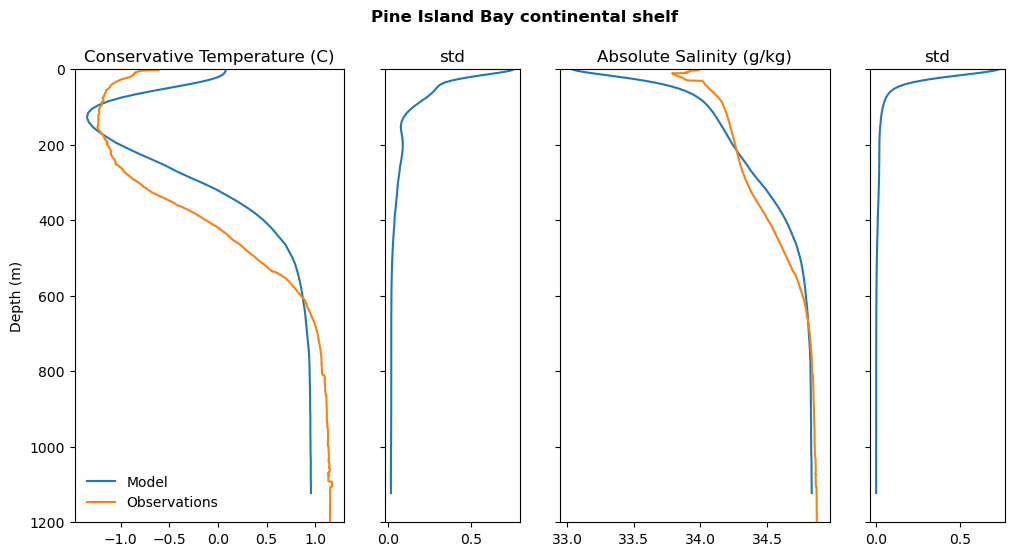

In [52]:
fig, ax = plt.subplots(1,4, figsize=(12,6), dpi=100, gridspec_kw={'width_ratios': [2, 1, 2, 1]})

for n, axis in enumerate(ax.ravel()):
    axis.set_ylim(1200, 0)
    if n!=0:
        axis.yaxis.set_ticklabels([])

# plotting
ax[0].plot(nemo_T_masked.mean(dim=['x','y','time_counter']), nemo_T.deptht           , label='Model')
ax[0].plot(obs_T_masked.mean(dim=['lon','lat']), abs(obs_T_masked.depth), label='Observations')
ax[2].plot(nemo_S_masked.mean(dim=['x','y','time_counter']), nemo_T.deptht)
ax[2].plot(obs_S_masked.mean(dim=['lon','lat']), abs(obs_S_masked.depth))

# ax[1].plot(nemo_T_masked.mean(dim=['x','y']).std(dim='time_counter'), nemo_T.deptht)
# ax[1].plot(nemo_T_masked.mean(dim=['x','y']).std(dim='time_counter'), nemo_T.deptht)
# ax[3].plot(nemo_S_masked.mean(dim=['x','y']).std(dim='time_counter'), nemo_S.deptht)

#labelling
fig.suptitle(f'{region_name}', fontweight='bold')
ax[0].legend(frameon=False)
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Conservative Temperature (C)')
ax[1].set_title('std')
ax[2].set_title('Absolute Salinity (g/kg)')
ax[3].set_title('std')